In [5]:
# -*- coding: utf-8 -*-

import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
plt.close('all')
import kenmerkendewaarden as kw

# set logging level to INFO to get log messages
# calling basicConfig is essential to set logging level of single module, format is optional
import logging
logging.basicConfig(format='%(message)s')
logging.getLogger("kenmerkendewaarden").setLevel(level="INFO")


# TODO: overview of data improvements: https://github.com/Deltares-research/kenmerkendewaarden/issues/29
# TODO: overview of data issues in https://github.com/Deltares-research/kenmerkendewaarden/issues/4
# TODO: missings/duplicates reported in https://github.com/Rijkswaterstaat/wm-ws-dl/issues/39. Some of the duplicates are not retrieved since we use clean_df in ddlpy

retrieve_meas_amount = False
plot_meas_amount = False
retrieve_meas = False
derive_stats = False
plot_meas = False
plot_stations = True
test = False

# TODO: add timezone to start/stop date? (and re-retrieve all data): https://github.com/Deltares-research/kenmerkendewaarden/issues/29
start_date = "1870-01-01"
end_date = "2024-01-01"
if test:
    start_date = "2021-12-01"
    end_date = "2022-02-01"
    # start_date = "2010-12-01"
    # end_date = "2022-02-01"

# dir_base = r'p:\11208031-010-kenmerkende-waarden-k\work'
dir_base = r"p:\11210325-005-kenmerkende-waarden\work"
dir_meas = os.path.join(dir_base, f"measurements_wl_{start_date.replace('-','')}_{end_date.replace('-','')}")
os.makedirs(dir_meas, exist_ok=True)
dir_meas_amount = os.path.join(dir_base, f"measurements_amount_wl_{start_date.replace('-','')}_{end_date.replace('-','')}")
os.makedirs(dir_meas_amount, exist_ok=True)


# all stations from TK (dataTKdia)
station_list = ['A12','AWGPFM','BAALHK','BATH','BERGSDSWT','BROUWHVSGT02','BROUWHVSGT08','GATVBSLE','BRESKVHVN','CADZD',
                'D15','DELFZL','DENHDR','EEMSHVN','EURPFM','F16','F3PFM','HARVT10','HANSWT','HARLGN','HOEKVHLD','HOLWD','HUIBGT',
                'IJMDBTHVN','IJMDSMPL','J6','K13APFM','K14PFM','KATSBTN','KORNWDZBTN','KRAMMSZWT','L9PFM','LAUWOG','LICHTELGRE',
                'MARLGT','NES','NIEUWSTZL','NORTHCMRT','DENOVBTN','OOSTSDE04','OOSTSDE11','OOSTSDE14','OUDSD','OVLVHWT','Q1',
                'ROOMPBNN','ROOMPBTN','SCHAARVDND','SCHEVNGN','SCHIERMNOG','SINTANLHVSGR','STAVNSE','STELLDBTN','TERNZN','TERSLNZE','TEXNZE',
                'VLAKTVDRN','VLIELHVN','VLISSGN','WALSODN','WESTKPLE','WESTTSLG','WIERMGDN','YERSKE']
station_list = ["VLISSGN","HOEKVHLD","IJMDBTHVN","HARLGN","DENHDR","DELFZL","SCHIERMNOG","VLIELHVN","STELLDBTN","SCHEVNGN","ROOMPBTN"] # subset of 11 stations along the coast
# TODO: maybe add from Dillingh 2013: DORDT, MAASMSMPL, PETTZD, ROTTDM
# station_list = ['BERGSDSWT']

# skip duplicate code stations from station_list_tk (hist/realtime) # TODO: avoid this https://github.com/Rijkswaterstaat/wm-ws-dl/issues/12 and https://github.com/Rijkswaterstaat/wm-ws-dl/issues/20
stations_realtime_hist_dupl = ["BATH", "D15", "J6", "NES"]
# skip MSL/NAP duplicate stations from station_list_tk # TODO: avoid this: https://github.com/Rijkswaterstaat/wm-ws-dl/issues/17
stations_nap_mls_dupl = ["EURPFM", "LICHTELGRE"]
stations_dupl = stations_realtime_hist_dupl + stations_nap_mls_dupl


### RETRIEVE MEASUREMENTS AMOUNT
if retrieve_meas_amount:
    kw.retrieve_measurements_amount(dir_output=dir_meas_amount, station_list=station_list, 
                                    start_date=start_date, end_date=end_date,
                                    extremes=False)
    kw.retrieve_measurements_amount(dir_output=dir_meas_amount, station_list=station_list, 
                                    start_date=start_date, end_date=end_date,
                                    extremes=True)


### PLOT MEASUREMENTS AMOUNT
if plot_meas_amount:
    df_amount_ts = kw.read_measurements_amount(dir_output=dir_meas_amount, extremes=False)
    df_amount_ext = kw.read_measurements_amount(dir_output=dir_meas_amount, extremes=True)
    
    file_plot = os.path.join(dir_meas_amount, "data_amount")
    
    fig, ax = kw.df_amount_pcolormesh(df_amount_ts, relative=True)
    fig.savefig(file_plot + "_ts_pcolormesh_relative", dpi=200)
    fig, ax = kw.df_amount_pcolormesh(df_amount_ext, relative=True)
    fig.savefig(file_plot + "_ext_pcolormesh_relative", dpi=200)
    


### RETRIEVE DATA FROM DDL AND WRITE TO NETCDF
for current_station in station_list:
    if not retrieve_meas:
        continue
    
    if current_station in stations_dupl:
        continue
    
    kw.retrieve_measurements(dir_output=dir_meas, station=current_station, extremes=False,
                             start_date=start_date, end_date=end_date)
    kw.retrieve_measurements(dir_output=dir_meas, station=current_station, extremes=True,
                             start_date=start_date, end_date=end_date)



### CREATE SUMMARY
if derive_stats:
    stats_ts = kw.derive_statistics(dir_output=dir_meas, station_list=station_list, extremes=False)
    stats_ext = kw.derive_statistics(dir_output=dir_meas, station_list=station_list, extremes=True)
    stats_ts.to_csv(os.path.join(dir_meas,'data_summary_ts.csv'))
    stats_ext.to_csv(os.path.join(dir_meas,'data_summary_ext.csv'))



### PLOT TIMESERIES DATA
for current_station in station_list:
    if not plot_meas:
        continue
    
    if current_station in stations_dupl:
        continue
    print(f'plotting timeseries data for {current_station}')
    
    # load data
    df_ts_meas = kw.read_measurements(dir_output=dir_meas, station=current_station, extremes=False)
    df_ext_meas = kw.read_measurements(dir_output=dir_meas, station=current_station, extremes=True)
    
    # create and save figure
    fig,(ax1, ax2) = kw.plot_measurements(df=df_ts_meas, df_ext=df_ext_meas)
    file_wl_png = os.path.join(dir_meas,f'ts_{current_station}.png')
    ax1.set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date)) # entire period
    fig.savefig(file_wl_png.replace('.png','_alldata.png'))
    ax1.set_xlim(dt.datetime(2000,1,1),dt.datetime(2024,1,1)) # period of interest
    fig.savefig(file_wl_png.replace('.png','_2000_2024.png'))
    plt.close(fig)



loading DDL locations catalog from pickle


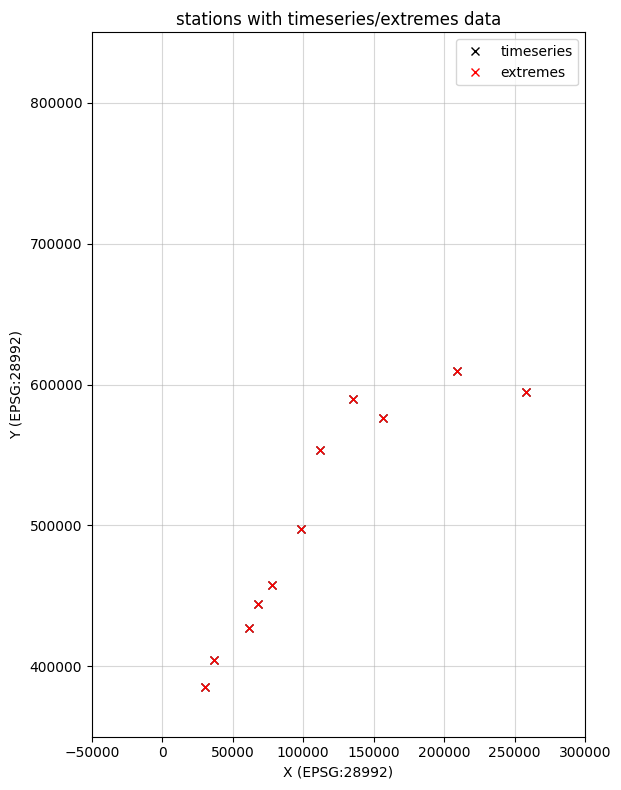

In [23]:
### PLOT SELECTION OF AVAILABLE STATIONS ON MAP
if plot_stations:
    crs = 28992
    locs_meas_ts, locs_meas_ext, _ = kw.data_retrieve.retrieve_catalog(crs=crs)
    locs_ts_sel = locs_meas_ts.loc[station_list]
    locs_ext_sel = locs_meas_ext.loc[locs_meas_ext.index.isin(station_list)]
    
    fig_map,ax_map = plt.subplots(figsize=(8,8))
    ax_map.plot(locs_ts_sel['X'], locs_ts_sel['Y'],'xk', label="timeseries")
    ax_map.plot(locs_ext_sel['X'], locs_ext_sel['Y'],'xr', label="extremes")
    ax_map.legend()
    
    """
    for iR, row in locs_ts_sel.iterrows():
        ax_map.text(row['X'],row['Y'],row.name)
    """
    ax_map.set_xlim(-50000,300000) # RD
    ax_map.set_ylim(350000,850000) # RD
    ax_map.set_title('stations with timeseries/extremes data')
    ax_map.set_aspect('equal')
    ax_map.set_xlabel(f'X (EPSG:{crs})')
    ax_map.set_ylabel(f'Y (EPSG:{crs})')
    ax_map.grid(alpha=0.5)
    
    # optionally add basemap/coastlines
    try:
        import dfm_tools as dfmt # pip install dfm_tools
        dfmt.plot_coastlines(ax=ax_map, crs=crs)
        dfmt.plot_borders(ax=ax_map, crs=crs)
    except ModuleNotFoundError:
        try:
            import contextily as ctx # pip install contextily
            ctx.add_basemap(ax_map, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
        except ModuleNotFoundError:
            pass
    
    fig_map.tight_layout()
    fig_map.savefig(os.path.join(dir_base,'stations_map.png'), dpi=200)




In [24]:
import geopandas as gpd
from shapely.geometry import Point
import folium

In [30]:
def create_gdf_points(df, epsg):
    geometry = [Point(xy) for xy in zip(df['X'], df['Y'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=epsg)
    gdf.to_file("data28992.geojson", driver="GeoJSON")
    gdf = gdf.to_crs("EPSG:4326")
    gdf.to_file("data4326.geojson", driver="GeoJSON")
    return gdf

def create_map(gdf):
    center_lat, center_lon = gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()
    mymap = folium.Map(location=[center_lat, center_lon], zoom_start=10)
    return mymap

def add_points_to_map(gdf, mymap):
    for idx, row in gdf.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5,  # Adjust the radius as needed
            color='blue',  # Circle color
            fill=True,
            fill_color='blue',  # Fill color
            fill_opacity=0.6,
            popup=f"Point {idx}"
        ).add_to(mymap)

    return mymap

gdf = create_gdf_points(locs_ext_sel,"EPSG:28992")
mymap = create_map(gdf)
mymap = add_points_to_map(gdf, mymap)
mymap

C:\Users\fuentesm\AppData\Local\Temp\ipykernel_11364\289403424.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat, center_lon = gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()
